<a href="https://colab.research.google.com/github/blancavazquez/diplomado_IA/blob/main/notebooks/Tema_02/Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulo 11: Introducción a las redes neuronales
# Tema 2: Redes densas
## Sobreajuste y regularización

El objetivo de esta libreta es construir una red neuronal densa sencilla para clasificar imágenes. En particular, en esta red se analizará la presencia de capas de dropout como estrategia de regularización. Para esti se crearán dos redes, una con capas de droput y una sin droput. El objetivo es graficar la pérdida durante el entrenamiento y observar las diferencias.

En esta libreta se usarán los datos de [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). El conjunto de datos CIFAR-10 consta de 60000 imágenes en color de 32x32 en 10 clases, con 6000 imágenes por clase. Hay 50.000 imágenes de entrenamiento y 10.000 imágenes de prueba.

In [4]:
!pip install wandb -qU

In [5]:
!pip install lightning

## Paso 1: Carga de bibliotecas

In [6]:
import os
import torch
import numpy as np
import torchvision
from torch import nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from pytorch_lightning.loggers.csv_logs import CSVLogger

In [7]:
#Biblioteca para visualizar la pérdida durante el entrenamiento
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Paso 2: Carga de datos

In [9]:
#Función para transformar las imágenes a tensor y normalizándolas-
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

#Descarga y carga de datos
batch_size = 32
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

#Generando los cargadores de datos
trainset = torch.utils.data.Subset(trainset, np.random.choice(len(trainset), 5000, replace=False))
testset = torch.utils.data.Subset(testset, np.random.choice(len(testset), 1000, replace=False))
print("train_subset: ", len(trainset), "test_subset: ", len(testset))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

CLASS_NAMES = ("plane", "car", "bird", "cat",
               "deer", "dog", "frog", "horse",
               "ship", "truck")

100%|██████████| 170M/170M [00:02<00:00, 79.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
train_subset:  5000 test_subset:  1000


Visualizamos algunas imágenes del conjunto de datos CIFAR10

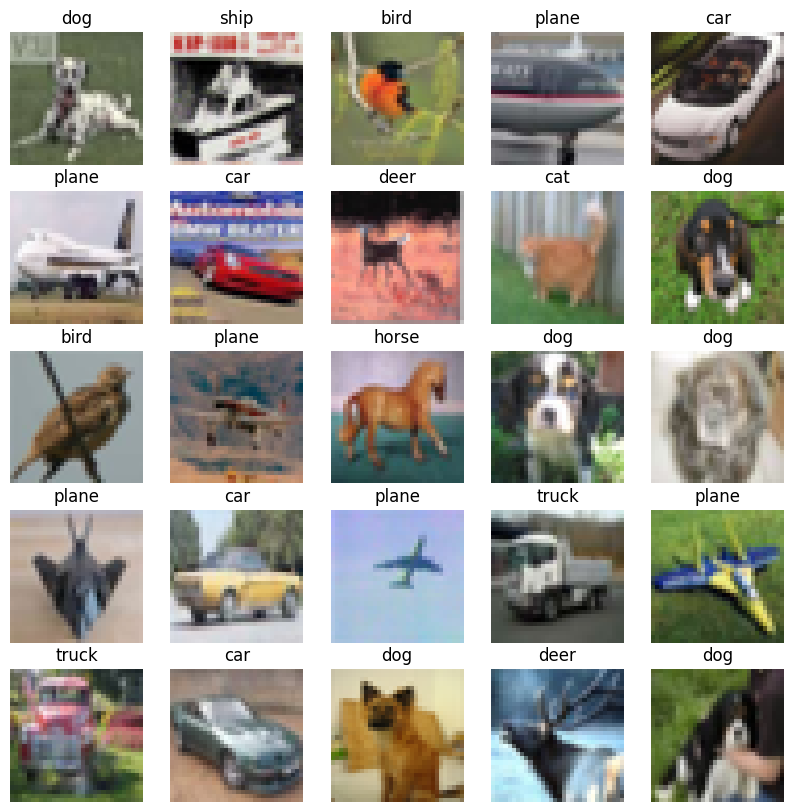

In [10]:
def show_batch(image_batch, label_batch):
  #Función para visualizar algunas imágenes de CIFA10
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      img = image_batch[n] / 2 + 0.5     # unnormalize
      img = img.numpy()
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.title(CLASS_NAMES[label_batch[n]])
      plt.axis("off")

sample_images, sample_labels = next(iter(trainloader))
show_batch(sample_images, sample_labels)

## Paso 3: Definición de la arquitectura del modelo

Se construye una arquitectura simple: con 3 capas.
* La primera capa recibe la imagen de entra (3 x 32 x 32) y la aplana. Esta capa está compuesta de 128 neuronas.
* La segunda capa tiene 128 neuronas de entrada y 64 de salida
* La tercera capa es la de salida, con 10 neuronas (una por cada clase)

In [11]:
class lineal_net(nn.Module):
    def __init__(self):
        super(lineal_net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.Dropout(p=0.2)) # Flatten the 32x32 RGB images
        self.fc2 = nn.Linear(128, 64) #capa intermedia
        self.fc3 = nn.Linear(64, 10)  # Capa de salida con 10 clases

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  # Aplanado de las imágenes de entrada
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Paso 4: Entrenamiento del modelo

In [12]:
class Lit_lineal_net(pl.LightningModule):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def training_step(self, batch, batch_idx):
    x, y = batch
    # print(y)
    out = self.model(x)
    # print(out)
    loss = criterion(out, y)
    preds = torch.argmax(out, dim=1)
    accuracy = torch.sum(preds == y).item() / y.size(0)

    self.log('train_loss', loss,  on_epoch=True)  # Log training loss
    self.log('train_accuracy', accuracy,  on_epoch=True)
    wandb.log({"Train Loss": loss, "Train Accuracy": accuracy})
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
    return optimizer

In [ ]:
#Función de pérdida
criterion = nn.CrossEntropyLoss()

#Instanciando el modelo
model = Lit_lineal_net(lineal_net())

#Variables para la visualización
wandb.init(project="dropout")
wandb.watch(model, log="all")

#Entrenamiento de la red
trainer = pl.Trainer(max_epochs=100,  logger=CSVLogger("logs"))
trainer.fit(model = model, train_dataloaders=trainloader)

print("Finished Training")
wandb.finish()

wandb: Currently logged in as: blancavazquez2013 (arbio). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | lineal_net | 402 K  | train
---------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | lineal_net | 402 K  | train
---------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
6         Modules in train mode
0     

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

## Ejercicio
Usando la arquitectura anterior, evalúa el rendimiento de la red cuando:

1. Cambias la tasa de dropout.
2. Añades varias capas de droput
3. Eliminar la capa de droput

¿Observas alguna diferencia? ¿Mejora la exactitud del modelo?, ¿Qué pasa con la pérdida?